# Interactive dEB light curve "quick" fitting tool

In [5]:
# A vain attempt to suppress excessive TF info/warn messages
%env TF_CPP_MIN_LOG_LEVEL 2

env: TF_CPP_MIN_LOG_LEVEL=2


In [6]:
import sys
from pathlib import Path
import re
from ast import literal_eval
import warnings
import copy

import numpy as np
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from mocpy import MOC
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
import lightkurve as lk

warnings.filterwarnings("ignore", "Using UFloat objects with std_dev==0 may give unexpected results.", category=UserWarning)
from uncertainties import UFloat, ufloat
from uncertainties.unumpy import nominal_values

#%matplotlib widget 
import matplotlib.pyplot as plt

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *
from ipyaladin import Aladin, Marker

# Dereddening of SEDS
from dust_extinction.parameter_averages import G23

# MCMC for SEDS
import corner

from sed_fit.stellar_grids import BtSettlGrid, KuruczGrid
from sed_fit.fitter import create_theta, model_func, minimize_fit, mcmc_fit, samples_from_sampler

from deblib.constants import G, R_sun, M_sun
from ebop_maven.estimator import Estimator
from libs import lightcurves, pipeline, plots, jktebop, extinction
from libs.targets import Targets
from libs.pipeline import nominal_value
from libs.sed import get_sed_for_target, group_and_average_fluxes, create_outliers_mask

<img src="https://www.aanda.org/articles/aa/full_html/2025/02/aa52325-24/aa52325-24-fig3.jpg" alt="Image by Nascimbeni et al. (2025)" width="750"/>

The PLATO LOPS2 long-pointing field as defined by [Nascimbeni et al. (2025)](https://ui.adsabs.harvard.edu/abs/2025A&A...694A.313N) with the HEALPix grids published at [zenodo](https://zenodo.org/records/14720127). 

In [7]:
# MOC (multi-order coverage map) for querying the full LOPS2 field (regardless of the ncam coverage)
lops_moc = MOC.load(path="libs/data/lops2-footprints-moc/PLATOfootprint_hpix9_full_v2.fits")

# Get all targets common to both LOPS2 and the source catalogue and TESS-ebs
all_tebs_lops = lops_moc.query_vizier_table("J/ApJS/258/16")
all_tebs_lops.sort("TIC")

In [8]:
tess_ebs_catalog = Vizier(catalog="J/ApJS/258/16", row_limit=1)
gaia_tbosb_catalog = Vizier(catalog="I/357/tbosb2", row_limit=1)
estimator = Estimator()

Estimator loading '/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/ebop_maven/data/estimator/default-model.keras'...loaded 'CNN-Rev1-Ext0-bP-4096-None-1000k'.
The model CNN-Rev1-Ext0-bP-4096-None-1000k was created at 2025-09-18T18:21:13+00:00
The input features are:
  mags_feature as a NDarray[float] of shape (#instances, 4096) containing a phase folded light curve centred on the mid-point between the primary and secondary eclipse
  extra_features as a NDarray of shape (#instances, 0) or None, as no extra_features are used for predictions
The prediction results are:
  predicted values as a structured NDarray[UFloat] of shape (#instances, [rA_plus_rB, k, J, ecosw, esinw, bP])
  optionally, if include_raw is True, all MC predictions as a NDArray[float] of shape (#instances, 6, #iterations)


### Select the target 
You can select from the TESS-ebs targets within the LOPS2 field or specify your own target.

The target is the object name value used on plots, messages and local cache folder.
The search term is used to search for assets in MAST, which can be the target name
(with or without a V* prefix) or a TIC identifier (9 digit numeric value). The exposure time
constrains the results by the cadence of the observations recorded. For more details see the 
[lightkurve documentation](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.search_lightcurve.html).

In [9]:
# This section is based on the targets being a subset of the TESS-ebs catalogue
targets_config = Targets("config/plato-lops2-tess-ebs-targets.json")

# # Explicit set of targets - we want these systems only
# targets_config = Targets("config/plato-lops2-tess-ebs-explicit-targets.json")

# Explicit set of test targets with known characterisation - we want these systems only
# targets_config = Targets("config/formal-test-explicit-targets.json")

if _target_ids := targets_config.get_known_target_ids(omit_excluded=True):
    print(f"Using {len(_target_ids)} explicitly configured target(s) within the config json.")
    target_ops = [(f"{t}", targets_config.get(t).get("search_term", t)) for t in _target_ids]
else:
    # We want to select only those targets within the TESS-ebs morphology and/or period criteria.
    _tebs_mask = np.ones(len(all_tebs_lops), dtype=bool)
    for _field, _filter in [("Morph", [0, 0.6]), ("Per", [0, np.inf])]:   
        _tebs_mask &= (all_tebs_lops[_field] >= min(_filter)) & (all_tebs_lops[_field] <= max(_filter))

    print(f"Found {len(all_tebs_lops)} target(s) from the TESS-ebs catalog within the LOPS2 field.\nWith",
            f"the application of morphology, period and exclusion criteria {sum(_tebs_mask)} remain.")
    target_ops = [(f"{t['TIC']} (Morph={t['Morph']:.3f}; Per={t['Per']:.3f} d)", t['TIC']) for t in all_tebs_lops[_tebs_mask]]

Found 556 target(s) from the TESS-ebs catalog within the LOPS2 field.
With the application of morphology, period and exclusion criteria 373 remain.


In [10]:
_default_target = "0140209204"
if not _default_target in [t[1] for t in target_ops]:
    _default_target = target_ops[0][1]

display(VBox(children=[
    HBox(children=[
        (_tebs_targs := Dropdown(description="TESS-ebs :", options=target_ops, value=_default_target, layout={'width': "max-content"})),
    ]),
    HBox(children=[
        (target_text := Text(description="target :", value="", placeholder="name or TIC")),
        (do_prefix := Checkbox(description="prefix non-numeric search term with V*", value=True, layout={'width': "max-content"} )),
    ]),
]))

dlink((_tebs_targs, 'value'), (target_text, 'value'))

### Review Target Information and refine the search

In [11]:
target = f"TIC {int(target_text.value):d}" if target_text.value.isnumeric() else target_text.value
target_config = targets_config.get(target_text.value, fallback_to_default=True)
target_data = {
    "target": target,
    "search_term": f"V* {target}" if not target.startswith("TIC") and do_prefix.value else target,
    **{ k: target_config.get(k, d) for k, d in 
                    zip(["t0", "period", "morph", "durP", "durS", "phiP", "phiS", "double_period", "Teff_sys", "logg_sys"],
                        [None, None, 0.5, None, None, 0.0, 0.5, False, None, None]) }
}

print(f"The chosen target is '{target}' with search_term '{target_data['search_term']}'")

target_coords = None
_simbad = Simbad()
_simbad.add_votable_fields("parallax", "allfluxes", "sp", "ids")
if (_tbl := _simbad.query_object(target_data["search_term"])):
    target_ids = np.array(re.findall(r"(Gaia DR3|V\*|TIC|HD|HIP|2MASS)\s+(.+?(?=\||$))", _tbl["ids"][0]),
                                         dtype=[("type", object), ("id", object)])
    print(f"AKA:       ",
          ", ".join(id for i in target_ids if (id:=f"{i[0]} {i[1]}") not in [target_data["search_term"], target]))
    
    target_data["coords"] = SkyCoord(ra=_tbl["ra"][0] * _tbl["ra"].unit, dec=_tbl["dec"][0] * _tbl["dec"].unit,
                                     distance=1000 / _tbl["plx_value"][0] * u.pc)
    target_data["SpT"] = _tbl["sp_type"][0]
    print(f"SpT:       ", target_data["SpT"], f"\nCoords:    ", f"{target_data['coords']}".replace("\n", ""),
          f"[qual='{_tbl['plx_qual'][0]}', ref='{_tbl['plx_bibcode'][0]}']")

# If the target is in Gaia DR3 we can override the skycoords
if "Gaia DR3" in target_ids["type"] and (_gaia_dr3_id := target_ids[target_ids["type"] == "Gaia DR3"]["id"][0]):
    if (_job := Gaia.launch_job(f"SELECT TOP 1 * FROM gaiadr3.gaia_source WHERE source_id = {_gaia_dr3_id}")):
        _tbl = _job.get_results()
        if _tbl["parallax"][0] and _tbl["parallax"] > 0:
            target_data["coords"] = SkyCoord(ra=_tbl["ra"][0] * u.deg, dec=_tbl["dec"][0] * u.deg,
                                             distance=1000 / _tbl["parallax"][0] * u.pc, frame="icrs")
            print(f"DR3 Coords:", f"{target_data['coords']}".replace("\n", ""))
        elif target_coords:
            print(f"DR3 Coords: parallax missing or <0 so sticking with SIMBAD coords")
        print(f"DR3 ruwe:   {_tbl['ruwe'][0]:.3f} [rows={len(_tbl)}]")

if (_tess_ebs_data := pipeline.get_tess_ebs_data(target_data["search_term"])) is not None:
    target_data |= _tess_ebs_data
else:
    print(f"\033[93m\033[1mTarget {target} not found in TESS-ebs. Falling back on config values.\033[0m")

print(f"Ephemeris:  t0={target_data['t0']} (btjd), period={target_data['period']} d, morph={target_data['morph']:.3f}")
print(f"            durP={target_data['durP']} d, durS={target_data['durS']} d, phiS={target_data['phiS']:.3f}")

if (_tbl := gaia_tbosb_catalog.query_object(target_data["search_term"], radius=5. * u.arcsec)):
    print(f"Gaia TBOSB: period={_tbl[0]['Per'][0]:.6f} d, ecc={_tbl[0]['ecc'][0]:.6f},",
            f"omega={_tbl[0]['omega'][0]:.6f}, K1={_tbl[0]['K1'][0]:.6f}, K2={_tbl[0]['K2'][0]:.6f} [rows={len(_tbl)}]")
    if abs(nominal_value(target_data["period"]) - _tbl[0]['Per'][0]) > nominal_value(target_data["period"] * 0.1):
        print("\033[93m\033[1mTBOSB period differs significantly from TESS-ebs/config\033[0m")

The chosen target is 'TIC 140209204' with search_term 'TIC 140209204'
AKA:        Gaia DR3 2900782566250390272, V* BV  1194, V* SV Col, 2MASS J05385398-3337561
SpT:         
Coords:     <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)    (84.72492039, -33.6322728, 876.04029785)> [qual='A', ref='2020yCat.1350....0G']
DR3 Coords: <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)    (84.72492541, -33.63221533, 876.0471238)>
DR3 ruwe:   0.868 [rows=1]
Ephemeris:  t0=1438.58115+/-0.00009 (btjd), period=2.75207+/-0.00004 d, morph=0.528
            durP=0.121799997985363 d, durS=0.11800000071525574 d, phiS=0.500


In [12]:
# We'll apply any configured sector restrictions via the checkboxes
search_results = lk.search_lightcurve(target_data["search_term"], exptime=target_config.exptime,
                                      author=target_config.author, mission=target_config.mission)

# Then filter out any results that are for a different TIC. This is fragile as using a mask
# directly on a SearchResult is a mess; it may also affect the order in which results are yielded!
# We want results ordered/grouped by sector so we re-sort on sector then the default order.
if not all(_tic_mask := np.in1d(search_results.target_name, target_ids[target_ids["type"]=="TIC"]["id"])):
    search_results.table = search_results.table[_tic_mask]
search_results.table.sort(["sequence_number", "distance", "project", "sort_order", "year", "exptime"])

# Make configured selections. Process exclusions first so they're overidden by mention in sectors.
_selected = np.ones(len(search_results), dtype=bool)
if len((exclude_sectors := target_config.exclude_sectors) or []) > 0:
    _selected = np.in1d(search_results.table["sequence_number"], exclude_sectors, invert=True)
if len((sectors_flat := target_config.sectors_flat) or []) > 0:
    _selected = np.in1d(search_results.table["sequence_number"], sectors_flat)

# Give user a chance to override any pre-selection of sectors and set the flux column and quality bitmask
_target_box = Accordion(
    children=[
        VBox(children=(sec_checks := 
            [Checkbox(description="toggle all", value=True, indent=False)] + 
            [Checkbox(description=f"{r.mission[0]} ({r.year[0]}): author={r.author[0]}, target={r.target_name[0]}, exptime={r.exptime[0]}", value=bool(chk),
                    indent=False, layout={'width': "max-content"}) for r, chk in zip(search_results, _selected)]
        )),
        HBox(children=[
            (flux_column := widgets.Dropdown(description="flux_column :", options=["sap_flux", "pdcsap_flux"],
                                             value=target_config.flux_column, style={'description_width': 'max-content'})),
            (quality_bitmask := widgets.Dropdown(description="quality_bitmask :", options=["default", "hard", "hardest"],
                                                 value=target_config.quality_bitmask, style={'description_width': 'max-content'})),
        ])
    ],
    titles=[f"The {len(search_results)} sector(s) found for {target}", "Flux column and quality bitmask"])

def toggle_all(_):
    for cb in sec_checks[1:]: cb.value = sec_checks[0].value
sec_checks[0].observe(toggle_all)
_target_box.selected_index = 0
display(_target_box)

Accordion(children=(VBox(children=(Checkbox(value=True, description='toggle all', indent=False), Checkbox(valu…

### Download the light curves of the chosen sectors
For details of the flux_column and quality_bitmask arguments see the documentation for
[download](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.SearchResult.download.html#lightkurve.SearchResult.download).
The find_lightcurves() function will attempt to service the request from the
local cache in preference to contacting MAST.

In [13]:
_select_mask = np.array([sec_checks[i].value for i in range(1, len(sec_checks))], dtype=bool)
num_sectors = sum(_select_mask)
target_file_stem = re.sub(r"[^\w\d]", "-", target.lower())
lcs = lightcurves.load_lightcurves(search_results[_select_mask], quality_bitmask.value,
                                   flux_column.value, Path.cwd() / ".cache" / target_file_stem)

### Plot the selected light curves

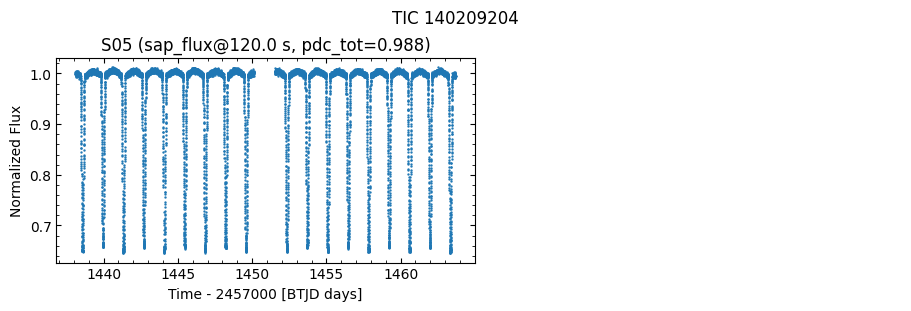

In [14]:
lcs_titles = [f"S{l.sector:02d} ({l.meta['FLUX_ORIGIN']}@{l.meta['FRAMETIM']*l.meta['NUM_FRM']} s, pdc_tot={l.meta['PDC_TOT']:.3f})" 
              for l in lcs]
fig = plots.plot_lightcurves(lcs, "flux", lcs_titles, normalize_lcs=True)
fig.suptitle(target)
plt.show(fig)

### Process the light curves to create flattened copies with delta_mag columns

First we select regions to exclude from processing. These could be distorted regions of the
light curve, incomplete eclipses or isolated regions with no useful data. Currently there is
no tool for selecting ranges from the light curve plot directly, so instead we parse the text
of an exclude list of (from, to) time tuples taken from all sectors. For example;
```python
[(1420.0, 1424.0), (2158.0, 2160.0)]
```
where the time values are interpreted with the time format and scale of each light curve.

Once we have any time masks we can use these, along with a simple mask which excludes
invalid flux values, to create masked copies of the original light curves. The masked
light curves are then extended with `delta_mag` and `delta_mag_err` columns calculated
from the fluxes. The `delta_mag` values are detrended and rectified in contiguous segments,
which are selected by finding gaps in the timeseries > gap threshold. Each segment is
rectified and detrended by subtracting a fitted polynomial of the selected degree. 

In [15]:
if target_config.sectors is not None and sorted(target_config.sectors_flat) == sorted(lcs.sector):
    _sector_default = target_config.sectors
else: # Default to fitting every sector separately
    _sector_default = [[s] for s in lcs.sector]

# The configured quality masks are regions to be clipped from the LCs because they're distorted.
# We also look to clip any short isolated regions of the LCs, as they often contain little
# useful information and often have a detrimental affect on the effectiveness of detrending.
quality_masks = target_config.quality_masks or []
for lc in lcs:
    seg_gap_th = 60 * lc.meta['FRAMETIM'] *lc.meta['NUM_FRM'] * u.s
    for seg in lightcurves.find_lightcurve_segments(lc, seg_gap_th, yield_times=True):
        if max(seg) - min(seg) < 2 * u.d:
            quality_masks += [(min(seg).value, max(seg).value)]

display(VBox(children=[
    (sector_groups_text := Text(description="Sector and groups:", value=f"{_sector_default}",
                           layout={'width': "50%"}, style={'description_width': 'max-content'})),
    (time_masks_text := Text(description="Time ranges to clip:", value=f"{quality_masks}",
                             layout={'width': "50%"}, style={'description_width': 'max-content'})),

    (seg_gap_th := FloatLogSlider(description="segment gap threshold (d):", value=target_config.detrend_gap_threshold,
                                  base=10, min=-1, max=3, layout={"width": "25%"}, style={'description_width': 'max-content'})),
    HBox(children=[
        (poly_degr := IntSlider(description="detrend poly degree:", value=target_config.detrend_poly_degree,
                                min=1, max=4, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (dtrd_iters := IntSlider(description="detrend iterations:", value=target_config.detrend_iterations,
                                 min=1, max=4, layout={"width": "25%"}, style={'description_width': 'max-content'})),
])]))

In [16]:
time_mask_list = []
if len(time_masks_text.value.strip()): # Interpret the list of (from, to) tuples entered above
    time_mask_list = literal_eval(time_masks_text.value)
    if isinstance(time_mask_list, (tuple, int, float)):
        time_mask_list = [time_mask_list]

In [17]:
# These will drive any flattening of the light-curves out of eclipses
flatten_kwargs = target_config.get("flatten", None)
_period = nominal_value(target_data["period"]) * (2 if target_config.double_period else 1)

# Temp: hard coded to a specific target (in this case CM Dra)
if flatten_kwargs is None and target == "CM Dra":
    flatten_kwargs = lightcurves.create_flatten_kwargs_from_params(nominal_value(target_data["t0"]),
                                                                   _period,
                                                                   sum_r=0.13064,
                                                                   inc=89.5514,
                                                                   ecosw=-0.00163,
                                                                   esinw=0.0050)

if flatten_kwargs is not None and "period" not in flatten_kwargs:
    flatten_kwargs |= { "period": _period }
print("flatten_kwargs =", flatten_kwargs)

flatten_kwargs = None


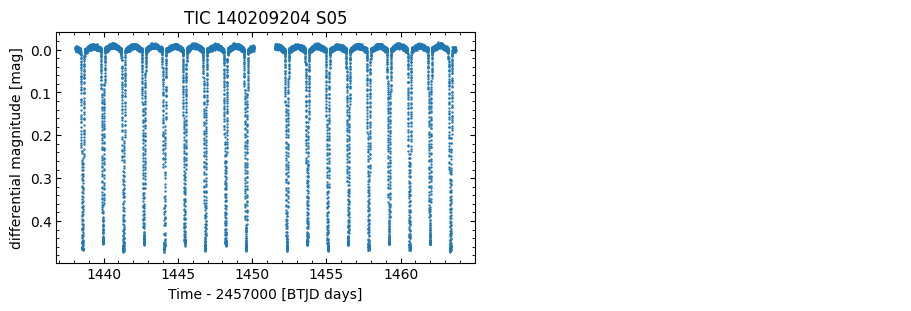

In [18]:
# Handle combining sectors
if len(sector_groups_text.value.strip()):
    sector_groups = literal_eval(sector_groups_text.value)
else:
    sector_groups = [[s] for s in lcs.sector]

mag_lcs = lk.LightCurveCollection([])
lcs_titles = []
for sector_group in sector_groups:
    # Normalize + combine the sectors in the grouping
    norm_lc = lcs[np.in1d(lcs.sector, sector_group)].stitch(lambda lc: lc.normalize())

    # Mask out any invalid fluxes and requested time ranges
    _qual_mask = lightcurves.create_invalid_flux_mask(norm_lc)
    for time_mask_range in (lightcurves.to_lc_time(t, norm_lc) for t in time_mask_list):
        _qual_mask &= (norm_lc.time < np.min(time_mask_range)) | (norm_lc.time > np.max(time_mask_range))
    norm_lc = norm_lc[_qual_mask]

    # Optionally flatten the LCs' out-of-eclipse fluxes.
    if flatten_kwargs is not None:
        norm_lc = lightcurves.flatten_lightcurve(norm_lc, **flatten_kwargs, verbose=True)

    # Create detrended & rectified delta_mag and delta_mag err columns
    lightcurves.append_magnitude_columns(norm_lc, "delta_mag", "delta_mag_err")
    for s in lightcurves.find_lightcurve_segments(norm_lc, threshold=seg_gap_th.value * u.d):
        norm_lc[s]["delta_mag"] -= lightcurves.fit_polynomial(norm_lc.time[s], norm_lc[s]["delta_mag"],
                                                              poly_degr.value, dtrd_iters.value, 1.0)

    mag_lcs.append(norm_lc)
    lcs_titles += [f"{target} S{'+'.join(f'{s:02d}' for s in sorted(sector_group))}"]

plt.show(plots.plot_lightcurves(mag_lcs, "delta_mag", lcs_titles))

### Review phase folded light curves
First we lookup for the system's ephemeris in the TESS-ebs catalogue based on its TIC. If nothing found then the primary epoch and orbital period must be set manually by inspecting the light curves above.

By default the T0 time is expected to be the time of a primary eclipse. The phase folded light curves will be phase normalized when folded about this point (which becomes phase 0).

In [19]:
display(HBox(children=[
    (t0_text := FloatText(description="Primary epoch (btjd):", value=nominal_value(target_data["t0"]),
                          style={'description_width': 'max-content'})),
    (period_text := FloatText(description="Orbital period (d):", value=nominal_value(target_data["period"]),
                              style={'description_width': 'max-content'})),
    (double_check := Checkbox(description="Use orbital period x2", value=target_data["double_period"],
                              style={"description_width": "max-content"})),
]))

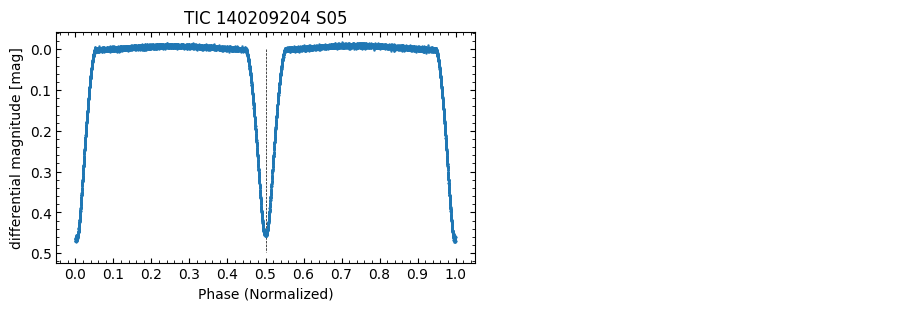

In [20]:
if t0_text.value != nominal_value(target_data["t0"]):
    target_data["t0"] = t0_text.value
if period_text.value != nominal_value(target_data["period"]):
    target_data["period"] = period_text.value
target_data["double_period"] = double_check.value

fold_t0 = lightcurves.to_lc_time(nominal_value(target_data["t0"]), mag_lcs[0])
fold_period = (2 if target_data["double_period"] else 1) * nominal_value(target_data["period"]) * u.d

def _format_phases(_, ax):
    ax.vlines([0.5], 0, max(ax.get_ylim()), "k", "--", lw=0.5, zorder=-10)
    ax.set_xticks(np.arange(0.0, 1.1, 0.1))

plt.show(plots.plot_lightcurves([*(lc.fold(fold_period, fold_t0, wrap_phase=u.Quantity(1), normalize_phase=True) for lc in mag_lcs)],
                                "delta_mag", lcs_titles, ax_func=_format_phases))

### Create sampled, phase folded mags data for use with EBOP MAVEN
We now need to make sampled copies of phase folded & phase normalized light curves for
each sector. The EBOP MAVEN model will tell us what wrap it expects for the folded light curves
for estimations through its `mags_feature_wrap_phase` attribute. This will have a value between
0 and 1, or `None`;
- a numeric value indicates the fixed phase above which phased data is expected to be wrapped
to a negative phase
    - a value of 0.75 indicates a phase range of -0.24999 to 0.75, centred on phase 0.25
- a value of `None` indicates the wrap is to ensure the resulting data is centred on the
mid-point between the primary and secondary eclipse
    - in this case the value is calculated from the phase of the secondary eclipse
    which can be set below

In [21]:
if estimator.mags_feature_wrap_phase is None:
    display(HBox(children=[
        (phiS_slider := FloatSlider(description="Phase of secondary eclipse:", value=nominal_value(target_data["phiS"]),
                                    min=.01, max=.99, step=.01, layout={"width": "33%"}, style={'description_width': 'max-content'})),
    ]))

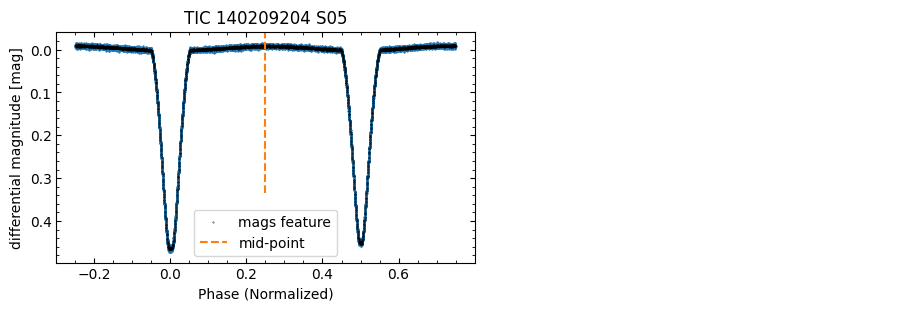

In [22]:
if phiS_slider.value != nominal_value(target_data["phiS"]):
    target_data["phiS"] = phiS_slider.value
mags_bins = estimator.mags_feature_bins
wrap_phase = u.Quantity(estimator.mags_feature_wrap_phase or (0.5 + nominal_value(target_data["phiS"]) / 2))
binned_fold = np.zeros(shape=(len(mag_lcs), 2, mags_bins), dtype=np.float32)

_flcs = []
for ix, lc in enumerate(mag_lcs):
    _flcs.append(flc := lc.fold(fold_period, fold_t0, wrap_phase=wrap_phase, normalize_phase=True))
    binned_fold[ix] = lightcurves.get_binned_phase_mags_data(flc, mags_bins, wrap_phase)

def _plot_feature_and_mid(ix, ax):
    ax.scatter(binned_fold[ix, 0], binned_fold[ix, 1], s=0.33, c="k", marker=".", label="mags feature")
    ax.vlines(0.5, 0.3, 1, "tab:orange", "--", lw=1.5, transform=ax.transAxes, label="mid-point")

plt.show(plots.plot_lightcurves(_flcs, "delta_mag", lcs_titles, ax_func=_plot_feature_and_mid, legend_loc="best"))

### Estimate fitting input parameters with EBOP MAVEN
The EBOP MAVEN model will predict values for $r_{\rm A}+r_{\rm B}$, $k$, $J$, $e\cos{\omega}$,
$e\sin{\omega}$ and $b_{\rm P}$ for use as `JKTEBOP` fitting input parameters. To these we will
need to add values for $i$, which can be calculated from the 6 predicted values.

In [23]:
predictions = estimator.predict(binned_fold[:, 1], iterations=1000)
predictions = pipeline.append_calculated_inc_predictions(predictions, "inc")

if predictions.size > 1:
    print(" Predicted for:   ", " ".join(f"{lt:^22s}" for lt in lcs_titles))
    for p in predictions.dtype.names:
        print(f"{p:>14s}: ", ", ".join(f"{predictions[ix][p]:9.3f}" for ix in range(predictions.size)))
    print()

print(("Mean p" if predictions.size > 1 else "P") + \
      f"redicted JKTEBOP input parameters for {target} over {predictions.size} folded light-curve(s)")
print("\n".join(f"{p:>14s}: {predictions[p].mean():12.6f}" for p in predictions.dtype.names), "\n")

Predicted JKTEBOP input parameters for TIC 140209204 over 1 folded light-curve(s)
    rA_plus_rB:     0.332427+/-    0.004780
             k:     1.412631+/-    0.028788
             J:     0.925685+/-    0.025807
         ecosw:    -0.000984+/-    0.004746
         esinw:     0.011367+/-    0.009413
            bP:     0.465118+/-    0.027496
           inc:    86.283273+/-    0.233460 



We have starting effective temperature and surface gravity values in the
TESS metadata stored with the light curves, however this refers to system
as a whole. We use J as a simple proxy for the ratio of effective temperatures.
We need an estimate of these to configure the limb darkening coefficients for the
light-curve fitting below.

In [24]:
_teff_sys = target_data["Teff_sys"] = target_data["Teff_sys"] or mag_lcs[0].meta.get("TEFF", None) or 5650
_logg_sys = target_data["logg_sys"] = target_data["logg_sys"] or mag_lcs[0].meta.get("LOGG", None) or 4.0

_teffr = predictions["J"].mean()**0.25 # With J*k^2 as a proxy for LR giving teff_rat ~ ((J*k^2)/k^2)^1/4
_teff = (_teff_sys, _teff_sys * _teffr) if _teffr.n < 1 else (_teff_sys / _teffr, _teff_sys)
display(VBox(children=[
    HBox(children=[
        (teffA_text := FloatSlider(description="Effective temp star A (K):", value=nominal_value(_teff[0]), min=2300, max=12000, step=5, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (loggA_text := FloatSlider(description="log(g) star A (dex):", value=nominal_value(_logg_sys), min=2.5, max=6.0, step=0.1, style={'description_width': 'max-content'})),    
    ]),
    HBox(children=[
        (teffB_text := FloatSlider(description="Effective temp star B (K):", value=nominal_value(_teff[1]), min=2300, max=12000, step=5, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (loggB_text := FloatSlider(description="log(g) star B (dex):", value=nominal_value(_logg_sys), min=2.5, max=6.0, step=0.1, style={'description_width': 'max-content'})),
    ]),
]))

Look for potential sources of third light in the region around the target.
Initialise the fitting of $L_3$ based on the findings.

In [25]:
if "Gaia DR3" in target_ids["type"]:
    _dr3_id = int(target_ids[target_ids["type"]=="Gaia DR3"]["id"][0])
    l3 = pipeline.estimate_l3_with_gaia(target_data["coords"], 120, target_source_id=_dr3_id, max_l3=0.5, verbose=True)
else:
    _g_mag = lcs[0].meta["TESSMAG"] # Estimate apparent g_mag of target
    l3 = pipeline.estimate_l3_with_gaia(target_data["coords"], 120, target_g_mag=_g_mag, max_l3=0.5, verbose=True)

display(VBox(children=[
    (l3_check := Checkbox(description="Fit for L3 (if unchecked fix at L3=0)",
                          value=True, style={"description_width": "max-content"})),
]))

_aview = Aladin(fov=0.5, reticle_size=64)
if target_data.get("coords", None) is not None:
    _aview.target = target_data["coords"]
_aview # Doesn't display if within an if or try block!

Target object has a Gaia magnitude of 11.7501 (4 d.p.)
Estimated the total third-light ratio (L3) to be 0.0197 (4 d.p.) for the 30 nearby object(s) found in Gaia DR3.


### Perform JKTEBOP Task 3 analysis

In [26]:
task = 3
iterations = 100 # only applies to task 8
fit_dir = jktebop.get_jktebop_dir()
file_fmt = f"quick-fit-{target_file_stem}-{{sector:04d}}.{{ext:s}}"

# Superset of all of the potentially fitted parameters
fitted_param_names = ["rA_plus_rB", "k", "J", "ecosw", "esinw", "inc", "L3", "pe", "period", "rA", "rB", "LA", "LB", "light_ratio", "qphot", "reflA", "reflB"]
fitted_params = np.empty(shape=(len(mag_lcs), ), dtype=[(k, np.dtype(UFloat.dtype)) for k in fitted_param_names])

fit_overrides = copy.deepcopy(target_config.get("jktebop_overrides", {}))
ld_params = pipeline.pop_and_complete_ld_config(fit_overrides, teffA_text.value, teffB_text.value,
                                                loggA_text.value, loggB_text.value, "pow2", True)

# Specific fit flags which may in future be modified by evaluation of target criteria
qphot = predictions["k"].mean()**1.4
qphot_fit = 0
refl_fit = -1 if (target_data["morph"] <= 0.2) else 1
grav_fit = 0
l3_fit = int(l3_check.value)
ecc_fit = 1

if ecc_fit == 0:
    fit_overrides["ecosw"] = 0
    fit_overrides["esinw"] = 0

for ix, (lc, preds) in enumerate(zip(mag_lcs, predictions)):
    _in_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="in")
    _dat_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="dat")
    _par_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="par")

    _in_params = {
        "task": task,

        # Mass ratio (qphot), can be -1 (force spherical) or a specified ratio
        "qphot": qphot,
        "gravA": 0.,                "gravB": 0.,
        "L3": l3 if l3_fit else 0,

        "reflA": 0.,                "reflB": 0.,
        "period": nominal_value(target_data["period"]) * (2 if target_data["double_period"] else 1),
        "primary_epoch": nominal_value(target_data["t0"]),
        
        "simulations": iterations if task == 8 else "",

        # Most fit flags can be 0 (fixed), 1 (freely fitted), ...
        # ... 2 (fixed, but perturbed in MC analysis) & 3 (freely fitted, but fixed for MC analysis)
        # The refl flags can be 0 (fixed), 1 (freely fitted) or -1 (calculated from sys geometry)
        "qphot_fit": qphot_fit,
        "ecosw_fit": ecc_fit,       "esinw_fit": ecc_fit,
        "gravA_fit": grav_fit,      "gravB_fit": grav_fit,
        "L3_fit": l3_fit,
        "LDA1_fit": 1,              "LDB1_fit": 1,
        "LDA2_fit": 0,              "LDB2_fit": 0,
        "reflA_fit": refl_fit,      "reflB_fit": refl_fit,
        "sf_fit": 1,
        "period_fit": 1,            "primary_epoch_fit": 1,

        "data_file_name": _dat_fname.name,
        "file_name_stem": _dat_fname.stem,

        **{ n: preds[n] for n in preds.dtype.names },
        **ld_params,
        **fit_overrides,
    }

    # JKTEBOP will fail if it finds files from a previous fitting
    for file in fit_dir.glob(file_fmt.format(sector=lc.meta["SECTOR"], ext="*")):
        file.unlink()
    _segments = lightcurves.find_lightcurve_segments(lc, 0.5, yield_times=True)
    _append_lines = jktebop.build_poly_instructions(_segments, "sf", 1) + ["", "chif", ""]
    jktebop.write_in_file(_in_fname, append_lines=_append_lines, **_in_params)
    jktebop.write_light_curve_to_dat_file(lc, _dat_fname)

    # Blocks on the JKTEBOP task until we can parse the newly written par file contents
    # to read out the revised values for the superset of potentially fitted parameters.
    _pgen = jktebop.run_jktebop_task(_in_fname, _par_fname, stdout_to=sys.stdout)
    for k, v in jktebop.read_fitted_params_from_par_lines(_pgen, fitted_param_names, True).items():
        fitted_params[ix][k] = v

Limb darkening params: StarA=pow2(0.60228063, 0.62752265), StarB=pow2(0.60663044, 0.64372912)
  
JKTEBOP  v44  John Southworth (Keele University, UK, taylorsouthworth~gmail.com)
Task 3  finds the best fit of the model to observations  (formal errorbars only)
>> Read parameters for polynomial  1, to be applied to parameter "sf" over a given time interval
>> Read parameters for polynomial  2, to be applied to parameter "sf" over a given time interval
>> Opened new parameter  file:  quick-fit-tic-140209204-0005.par                  
>> Opened new LC output  file:  quick-fit-tic-140209204-0005.out                  
>> Opened new model fit  file:  quick-fit-tic-140209204-0005.fit                  
>> Read  17204 datapoints (with errors) from file quick-fit-tic-140209204-0005.dat                  
>> Read  2 polynomial datasets from the input file
>> Best fit has been found after 22 iterations.
>> Done iteration 1 to adjust errorbars. Chisqred values:   0.991 
>> Done iteration 2 to adjust e

#### Report of JKTEBOP fitting results

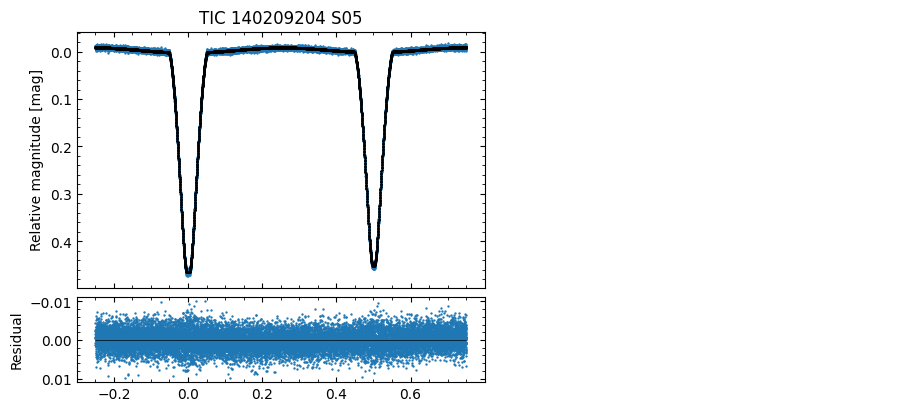

In [27]:
if task == 3:
    rows, cols = int(np.ceil(len(mag_lcs) / 2)), 2
    fig, axes = plt.subplots(rows*2, cols, figsize=(4.5*cols, 4*rows), height_ratios=(3, 1)*rows, constrained_layout=True)

    for ix in range(axes.size//2):
        row, col = int(np.floor(ix / cols) * 2), ix % cols
        ax_lc, ax_res = axes[row, col], axes[row+1, col]
        if ix < len(mag_lcs):
            # Pick columns so they are ordered [phase, lc_mag, model_mag, residual]
            out_file = fit_dir / file_fmt.format(sector=mag_lcs[ix].meta['SECTOR'], ext="out")
            out_data = np.loadtxt(out_file, float, comments="#", usecols=[3, 1, 4, 5], unpack=True)
            out_data[0][out_data[0] > wrap_phase.value] -= 1. # matches wrap used previously
        
            if ix < len(mag_lcs):
                ax_lc.scatter(out_data[0], out_data[1], s=2.0, marker=".", label=None)
                ax_lc.scatter(out_data[0], out_data[2], s=0.5, c="k", marker=".", label=None)
                ax_res.scatter(out_data[0], out_data[3], s=2.0, marker=".", label=None)
                ax_res.hlines([0.0], min(out_data[0]), max(out_data[0]), ls="-", color="k", lw=.5)

                if ix == 0:
                    ax_lc.invert_yaxis()
                    ax_res.invert_yaxis()
                else:
                    ax_lc.sharey(axes[0, 0])
                    ax_res.sharey(axes[1, 0])
        
                # Hides tick labels on inner facing shared axes
                plt.setp(ax_lc.get_xticklabels(), visible=False) 
                if col > 0:
                    plt.setp(ax_lc.get_yticklabels(), visible=False)
                    plt.setp(ax_res.get_yticklabels(), visible=False)
                plots.format_axes(ax_lc, title=lcs_titles[ix], ylabel="" if ix % cols else "Relative magnitude [mag]")
                plots.format_axes(ax_res, ylabel="" if ix % cols else "Residual")
        else:
            ax_lc.axis("off")
            ax_res.axis("off")
    plt.show(fig)

In [28]:
if fitted_params.size > 1:
    print("    Fitted for:   ", " ".join(f"{lt:^22s}" for lt in lcs_titles))
    for p in fitted_params.dtype.names:
        print(f"{p:>14s}: ", ", ".join(f"{fitted_params[p][ix]:9.3f}" for ix in range(fitted_params.size)))
    print()

print(("Mean f" if fitted_params.size > 1 else "F") + f"itted parameter values and",
        f"formal error bars for {target} over {fitted_params.size} sector(s)")
print("\n".join(f"{p:>14s}: {fitted_params[p].mean():12.6f}" for p in fitted_params.dtype.names), "\n")

target_data["Teff_ratio"] = (fitted_params["light_ratio"].mean() / fitted_params["k"].mean()**2)**0.25
target_data["radius_ratio"] = fitted_params["k"].mean()
print(f"    Teff_ratio: {target_data['Teff_ratio']:12.6f} (calculated from light_ratio & k)")

Fitted parameter values and formal error bars for TIC 140209204 over 1 sector(s)
    rA_plus_rB:     0.324886+/-    0.000191
             k:     1.419607+/-    0.004666
             J:     0.899362+/-    0.009473
         ecosw:    -0.000060+/-    0.000015
         esinw:    -0.001831+/-    0.001248
           inc:    86.986680+/-    0.035065
            L3:    -0.002652+/-    0.002625
            pe:  1438.581063+/-    0.000028
        period:     2.752120+/-    0.000005
            rA:     0.134272+/-           0
            rB:     0.190614+/-           0
            LA:     0.350177+/-           0
            LB:     0.652474+/-           0
   light_ratio:     1.863268+/-           0
         qphot:     1.621961+/-           0
         reflA:    -0.002751+/-    0.000076
         reflB:    -0.002283+/-    0.000074 

    Teff_ratio:     0.980584+/-    0.001612 (calculated from light_ratio & k)


### Load our support data for MCMC fitting the target's SED

In [29]:
# Extinction model: G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron
print(f"Using the {ext_model.__class__.__name__} extinction model which covers the range from",
      f"{min(ext_wl_range):unicode} to {max(ext_wl_range):unicode}.")

Using the G23 extinction model which covers the range from 0.0912 µm to 32.0 µm.


Loads a grid of fluxes, in this case derived from bt-settl-agss or Kurucz ODFNEW /NOVER models.
The StellarGrid classes are used by the SED fitting code to generate model SEDs for fitting.

In [30]:
# Model SED grid based on atmosphere models with known filters pre-applied to non-reddened fluxes
model_grid = BtSettlGrid(extinction_model=ext_model, verbose=True)
# model_grid = KuruczGrid(extinction_model=ext_model, verbose=True)

print(f"Loaded grid based on synthetic models, covering the ranges:")
print(f"wavelength {model_grid.wavelength_range * model_grid.wavelength_unit:unicode},",
      f"Teff {model_grid.teff_range * model_grid.teff_unit:unicode},",
      f"logg {model_grid.logg_range * model_grid.logg_unit:unicode}",
      f"\nand metallicity {model_grid.metal_range * u.dimensionless_unscaled:unicode},",
      f"with fluxes returned in units of {model_grid.flux_unit:unicode}")

Loading model grid from bt-settl-agss.npz created at 2025-11-19 18:41:01.266422+00:00
BtSettlGrid is initializing the fluxes interpolator with the grid of 112 teff, 6 logg & 4 metal values and 5000 wavelength bins...will use slinear interpolation...done.
Initializing unreddened fluxes for 39 filters.......................................done.
Loaded grid based on synthetic models, covering the ranges:
wavelength [ 0.09120575 31.99861909] µm, Teff [ 2000. 40000.] K, logg [3.  5.5] dex 
and metallicity [-0.5  0.5], with fluxes returned in units of W m⁻²


### Locate and prepare the target's spectral energy distribution (SED) data
We can query the target's SED with the Vizier SED service which aggregates
flux measurements from various systematic sky surveys. Once we have this
we need to deredden the SED prior to fitting for stellar masses

In [31]:
# Read in the SED for this target and de-duplicate (measurements may appear multiple times).
# Plots are unit agnostic and plot wl [um] and vF(v) [W/m^2] on x and y.
sed = get_sed_for_target(target, target_data["search_term"], radius=0.1, remove_duplicates=True, verbose=True)

sed = group_and_average_fluxes(sed, verbose=True)

# Filter SED to those covered by our models and also remove any outliers
model_mask = np.ones((len(sed)), dtype=bool)
model_mask &= model_grid.has_filter(sed["sed_filter"])
model_mask &= (sed["sed_wl"] >= min(ext_wl_range)) \
            & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(model_grid.wavelength_range)) \
            & (sed["sed_wl"] <= max(model_grid.wavelength_range))
sed = sed[model_mask]

out_mask = create_outliers_mask(sed, nominal_value(target_data["Teff_sys"]), [target_data["Teff_ratio"]], min_unmasked=15, verbose=True)
sed = sed[~out_mask]

sed.sort(["sed_wl"])
print(f"{len(sed)} unique SED observation(s) retained after range and outlier filtering",
      "\nwith the units for flux, frequency and wavelength being",
      ", ".join(f"{sed[f].unit:unicode}" for f in ["sed_flux", "sed_freq", "sed_wl"]))

Opened SED table tic-140209204-0.1.vot containing 77 row(s).
Dropped 32 duplicate(s) leaving 45 unique row(s).
Grouped SED by ['sed_filter', 'sed_freq'] yielding 17 group(s) from 45 row(s).
Calculating the group means of the [('sed_flux', 'sed_eflux')] columns
No outliers masked as already 15 or fewer SED rows
13 unique SED observation(s) retained after range and outlier filtering 
with the units for flux, frequency and wavelength being W Hz⁻¹ m⁻², Hz, µm


In [32]:
av = target_config.get("av", None)
if not av:
    # Get the mean of the various catalogues, prioritising converged results
    _ext_funcs = ["get_gontcharov_ebv", "get_bayestar_ebv"]
    for conv in [True, False]:
        avs = [v for v, flags in extinction.get_av(target_data["coords"], _ext_funcs, ext_model.Rv, True)
                    if flags.get("converged", False) == conv]
        if len(avs):
            av = np.mean(avs)
            print(f"Found mean extinction of {len(avs)} catalogue(s): A_V = {av:.6f}")
            break

if av:
    print(f"Dereddening observations with A_V={av:.3f}")
    sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Av=av)
    der_lab = "dereddened"
else:
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"

get_gontcharov_ebv=0.063 [converged=True]
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 26.804 s
  pix_info:   0.371 s
   samples:  14.910 s
      best:   3.041 s
       nan:   0.020 s
      sort:   8.376 s
       idx:   0.085 s
Found mean extinction of 1 catalogue(s): A_V = 0.195369
Dereddening observations with A_V=0.195


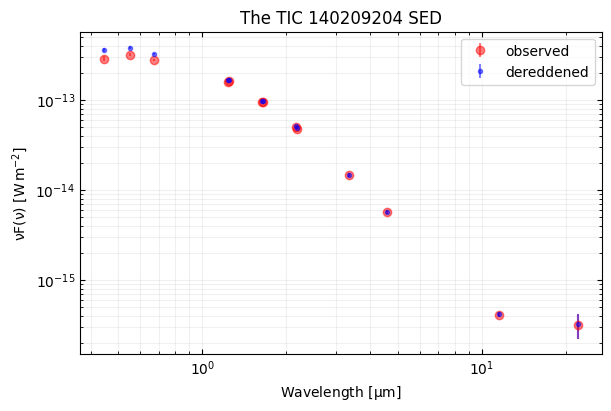

In [33]:
plt.show(plots.plot_sed(sed["sed_wl"].quantity,
                        fluxes=[sed["sed_flux"].quantity, sed["sed_der_flux"].quantity],
                        flux_errs=[sed["sed_eflux"].quantity]*2,
                        fmts=["or", ".b"],
                        labels=["observed", der_lab],
                        title=f"The {target} SED"))

### Set up the functions which will support SED fitting

We set the starting position for the fit, `theta0`, which is our best estimate of the
fitted values for the system based on existing published data and any light-curve fitting carried
out previously.

The `fit_mask` indicates which of the values in `theta0` is fitted, with the remainder being fixed.

**Note:** currently we're not fitting for $\log{g}$, instead using fixed values for each star.

In [34]:
NUM_STARS = 2

subs = "ABCDEFGHIJKLM"
theta_plot_labels = np.array([f"$T_{{\\rm eff,{subs[st]}}} / {{\\rm K}}$" for st in range(NUM_STARS)] \
                            +[f"$\\log{{g}}_{{\\rm {subs[st]}}}$" for st in range(NUM_STARS)] \
                            +[f"$R_{{\\rm {subs[st]}}} / {{\\rm R_{{\\odot}}}}$" for st in range(NUM_STARS)] \
                            +["${\\rm D} / {\\rm pc}$", "${\\rm A_{V}}$"])

theta_labels = np.array([(f"Teff{subs[st]}", u.K) for st in range(NUM_STARS)] \
                        +[(f"logg{subs[st]}", u.dex) for st in range(NUM_STARS)] \
                        +[(f"R{subs[st]}", u.Rsun) for st in range(NUM_STARS)] \
                        +[("D", u.pc), ("av", u.dimensionless_unscaled)])

In [35]:
theta0 = create_theta(teffs=nominal_value(target_data["Teff_sys"]),
                      loggs=nominal_value(target_data["logg_sys"]),
                      radii=1.0,
                      dist=target_data["coords"].distance.to(u.pc).value,
                      av=0,
                      nstars=NUM_STARS,
                      verbose=True)

fit_mask = np.array([True] * NUM_STARS      # teff
                  + [False] * NUM_STARS     # logg
                  + [True] * NUM_STARS      # radius
                  + [True]                  # dist
                  + [False])                # av (we've handled av by derredening the SED)

theta:	 6.562e+03, 6.562e+03, 3.731e+00, 3.731e+00, 1.000e+00, 1.000e+00, 8.760e+02, 0.000e+00


Here we set up priors' limit and ratio criteria for the fitting. This is in the form of a
callback function which the fitting code invokes at the start of each iteration.

In [36]:
# For now, hard coded to 2 stars. Same order as theta: teff, radii (, logg, dist are not fitted)
teff_limits = model_grid.teff_range
radius_limits = (0.1, 100)

# Ratios wrt the primary components - we ignore the 0th item
_teff_ratio, _radius_ratio = target_data["Teff_ratio"], target_data["radius_ratio"]
teff_ratios = [ufloat(_teff_ratio.n, max(_teff_ratio.s, _teff_ratio.n * 0.1))] * NUM_STARS
radius_ratios = [ufloat(_radius_ratio.n, max(_radius_ratio.s, _radius_ratio.n * 0.1))] * NUM_STARS

dist_prior = ufloat(target_data["coords"].distance.value, target_data["coords"].distance.value * 0.05)

def ln_prior_func(theta: np.ndarray[float]) -> float:
    """
    The fitting prior callback function to evaluate the current set of candidate
    parameters (theta), returning a single ln(value) indicating their "goodness".
    """
    teffs = theta[0:NUM_STARS]
    radii = theta[NUM_STARS*2:NUM_STARS*3]
    dist = theta[-2]

    # Limit criteria checks - hard pass/fail on these
    if not all(teff_limits[0] <= t <= teff_limits[1] for t in teffs) or \
        not all(radius_limits[0] <= r <= radius_limits[1] for r in radii):
        return np.inf

    # Gaussian prior criteria: g(x) = 1/(σ*sqrt(2*pi)) * exp(-1/2 * (x-µ)^2/σ^2)
    # Omitting scaling expressions for now and note the implicit ln() cancelling the exp
    ret_val = 0
    for star_ix in range(1, NUM_STARS):
        ret_val += ((teffs[star_ix] / teffs[0] - teff_ratios[star_ix].n) / _teff_ratio.s)**2
        ret_val += ((radii[star_ix] / radii[0] - radius_ratios[star_ix].n) / _teff_ratio.s)**2
    ret_val += ((dist - dist_prior.n) / dist_prior.s)**2
    return 0.5 * ret_val

Get the observed SED data into a format for fitting. Flux units need to match
those produced by the model grid.

In [37]:
# Prepare the data to be fitted
x = model_grid.get_filter_indices(sed["sed_filter"])
y = (sed["sed_der_flux"].quantity * sed["sed_freq"].quantity)\
                                    .to(model_grid.flux_unit, equivalencies=u.spectral()).value
y_err = (sed["sed_eflux"].quantity * sed["sed_freq"].quantity)\
                                    .to(model_grid.flux_unit, equivalencies=u.spectral()).value

#### Run a "quick" minimize fit

In [38]:
theta_min_fit, _ = minimize_fit(x, y, y_err=y_err, theta0=theta0, fit_mask=fit_mask,
                                ln_prior_func=ln_prior_func, stellar_grid=model_grid, verbose=True)

minimize_fit(theta0=[6.562e+03*, 6.562e+03*, 3.731e+00, 3.731e+00, 1.000e+00*, 1.000e+00*, 8.760e+02*, 0.000e+00])
(Nelder-Mead) succeeded after 407 iterations & 667 function evaluation(s) [fun = 1.620815]
(SLSQP) succeeded after 31 iterations & 199 function evaluation(s) [fun = 1.620815]
(None) failed [Desired error not necessarily achieved due to precision loss.] after 50 iterations & 576 function evaluation(s) [fun = 1.620815]
The best fit with Nelder-Mead method yielded theta=[6.512e+03*, 6.385e+03*, 3.731e+00, 3.731e+00, 1.601e+00*, 2.273e+00*, 8.760e+02*, 0.000e+00]


Best fit parameters for TIC 140209204 from minimization fit (* indicates fitted parameter):
       TeffA* = 6511.699 K
       TeffB* = 6385.272 K
       loggA  = 3.731 dex
       loggB  = 3.731 dex
          RA* = 1.601 R☉
          RB* = 2.273 R☉
           D* = 876.047 pc
          av  = 0.000 


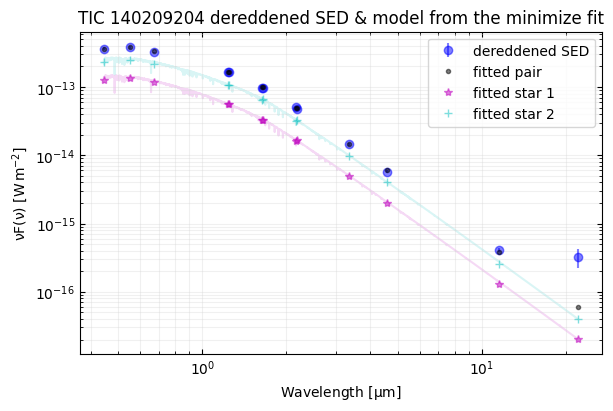

In [39]:
print(f"Best fit parameters for {target} from minimization fit (* indicates fitted parameter):")
for (k, unit), theta_val, mask in zip(theta_labels, theta_min_fit, fit_mask):
    print(f"{k:>12s}{'*' if mask else ' ':s} = {theta_val:.3f} {unit:unicode}")
    # *** Also updates the target_data ***
    target_data[k] = theta_val

plt.show(plots.plot_fitted_model(sed, theta_min_fit, model_grid,
                                 title=f"{target} dereddened SED & model from the minimize fit"))

#### Perform MCMC SED fitting for more reliable fit from a probability distribution

In [40]:
thin_by = 10 # sample every nth step from the chain
theta_mcmc_fit, sampler = mcmc_fit(x, y, y_err, theta0=theta_min_fit, fit_mask=fit_mask,
                                   ln_prior_func=ln_prior_func, stellar_grid=model_grid, 
                                   nwalkers=100, nsteps=100000, thin_by=thin_by, seed=42,
                                   early_stopping=True, processes=8, progress=True, verbose=True)

mcmc_fit(theta0=[6.512e+03*, 6.385e+03*, 3.731e+00, 3.731e+00, 1.601e+00*, 2.273e+00*, 8.760e+02*, 0.000e+00])
Running MCMC fit on 8 process(es) with 100 walkers for 100000 steps, sampling every 10 steps.
Early stopping is enabled after 12500 steps.


 14%|█▍        | 14000/100000 [06:56<42:41, 33.58it/s] 


Halting MCMC after 14000 steps as the walkers are past 100 times the autocorrelation time & the fit has converged.
Mean Acceptance fraction:    0.550
Autocorrelation steps (tau): 56.596, 56.625, 55.371, 55.483, 55.853
Estimated burn-in steps:     120
Leaving samples of shape:    (138800, 5) *flattened
The MCMC fit yielded theta:  [(6.509+/-0.115)e+03*, (6.383+/-0.112)e+03*, (3.731+/-0)e+00, (3.731+/-0)e+00, (1.610+/-0.085)e+00*, (2.286+/-0.121)e+00*, (8.805+/-0.435)e+02*, (0.000+/-0)e+00]


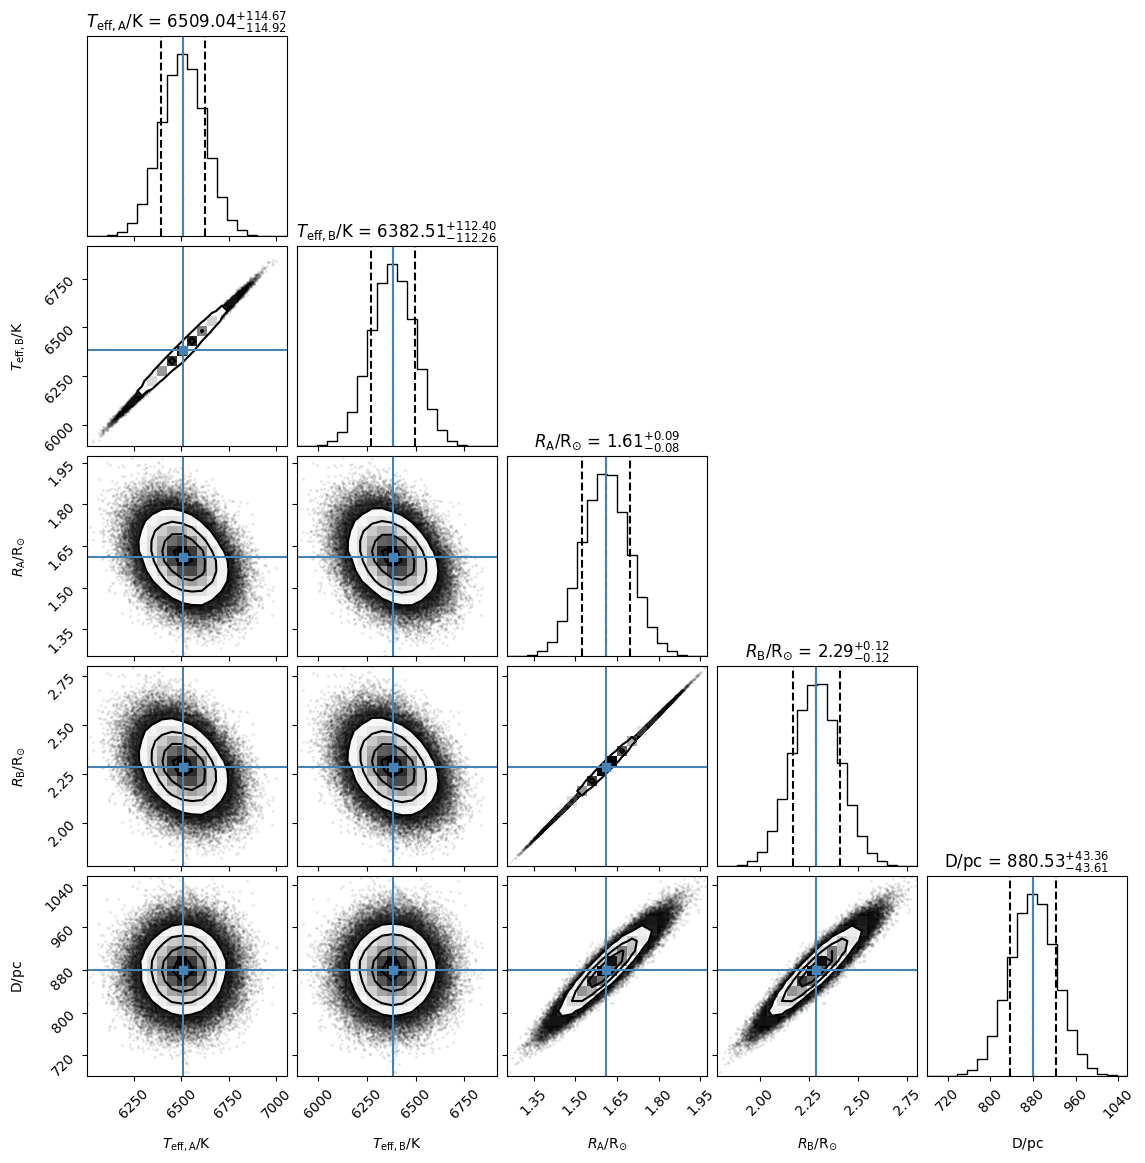

In [41]:
plt.show(corner.corner(data=samples_from_sampler(sampler, thin_by=thin_by, flat=True),
                       show_titles=True, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84],
                       labels=theta_plot_labels[fit_mask], truths=nominal_values(theta_mcmc_fit[fit_mask])))


Final parameters for TIC 140209204 with nominals & 1-sigma error bars from MCMC fit
       TeffA* = 6509.039+/-114.797 K 	 
       TeffB* = 6382.508+/-112.328 K 	 
       loggA  = 3.731+/-0 dex 	 
       loggB  = 3.731+/-0 dex 	 
          RA* = 1.610+/-0.085 R☉ 	 
          RB* = 2.286+/-0.121 R☉ 	 
           D* = 880.532+/-43.487 pc 	 (876.047 pc)
          av  = 0.000+/-0  	 


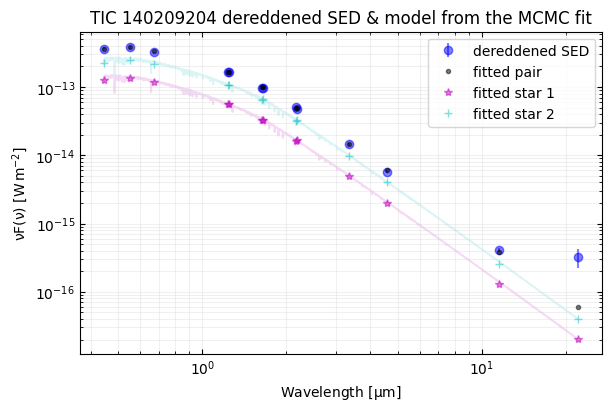

In [42]:
print(f"\nFinal parameters for {target} with nominals & 1-sigma error bars from MCMC fit")
for (k, unit), theta_val, mask in zip(theta_labels, theta_mcmc_fit, fit_mask):
    known = ""
    if k == "D":
        known = f"({target_data['coords'].distance.to(u.pc).value:.3f} pc)"
    elif target_config.get("labels", {}).get(k, None) is not None:
        value = ufloat(target_config.labels.get(k, np.NaN), target_config.labels.get(k + "_err", 0))
        known = f"({value:.3f} {unit:unicode})"
    print(f"{k:>12s}{'*' if mask else ' ':s} = {theta_val:.3f} {unit:unicode} \t", known)
    # *** also updates the target data ***
    target_data[k] = theta_val

plt.show(plots.plot_fitted_model(sed, theta_mcmc_fit, model_grid,
                                 title=f"{target} dereddened SED & model from the MCMC fit"))

### Find orbital parameters based on results of fitting

In [43]:
# semi-major axis
target_data["a"] = np.mean([target_data["RA"] / fitted_params["rA"].mean(),
                           target_data["RB"] / fitted_params["rB"].mean()])
print(f"semi-major axis (a):    {target_data['a']:.3f} {u.Rsun:unicode} (from fitted radii)")

# total mass of the system
target_data["mass_sys"] = (4 * np.pi**2 * (target_data["a"] * R_sun)**3) \
                        / (G * (fitted_params["period"].mean() * 86400)**2) / M_sun
print(f"total system mass:      {target_data['mass_sys']:.3f} {u.Msun:unicode} (from a & period)")

semi-major axis (a):    11.993+/-0.449 R☉ (from fitted radii)
total system mass:      3.056+/-0.343 M☉ (from a & period)


In [44]:
import libs.fit_masses as fit_masses

def print_mass_theta(theta, label: str="theta"):
    print(f"{label} = [" + ", ".join(f"{t:.3e}" for t in theta) + "]\n") 

# Priors: observations from SED fitting
obs_radii = np.array([target_data["RA"], target_data["RB"]])
obs_teffs = np.array([target_data["TeffA"], target_data["TeffB"]])

# Estimate fit starting position with masses based on the observed radii and a reasonable M-S age
_theta_masses = np.array([target_data["mass_sys"] * r for r in obs_radii])
_theta_masses *= (target_data["mass_sys"] / np.sum(_theta_masses))
_theta_age = [9.0 if max(nominal_values(_theta_masses)) <= 2.0 else 8.0]
mass_theta0 = np.concatenate([nominal_values(_theta_masses), _theta_age]) # initial masses and log age
print_mass_theta(mass_theta0, "mass_theta0")

mass_min_theta, _ = fit_masses.minimize_fit(mass_theta0, target_data["mass_sys"], obs_radii, obs_teffs, verbose=True)
print_mass_theta(mass_min_theta, "mass_min_theta")

Reading in: /home/steveo/projects/main/platodebcat/libs/data/mist/MIST_v1.2_vvcrit0.4_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_basic.iso
mass_theta0 = [1.263e+00, 1.793e+00, 9.000e+00]

(Nelder-Mead) succeeded after 72 iterations & 143 function evaluation(s) [fun = 1.240060]
(SLSQP) succeeded after 2 iterations & 18 function evaluation(s) [fun = 22.501388]
(None) failed [Desired error not necessarily achieved due to precision loss.] after 2 iterations & 179 function evaluation(s) [fun = 13.461863]
Taking the best fit from the Nelder-Mead method
mass_min_theta = [1.433e+00, 1.599e+00, 9.261e+00]



In [45]:
thin_by = 10
mass_mcmc_theta, mass_sampler = fit_masses.mcmc_fit(mass_min_theta, target_data["mass_sys"],
                                                    obs_radii, obs_teffs, nwalkers=100,
                                                    nsteps=100000, thin_by=thin_by, seed=42,
                                                    early_stopping=True, early_stopping_threshold=0.01,
                                                    processes=8, progress=True, verbose=True)
print_mass_theta(mass_mcmc_theta, "mass_mcmc_theta")

 18%|█▊        | 18000/100000 [03:07<14:13, 96.11it/s] 


Halting MCMC after 18000 steps as the walkers are past 100 times the autocorrelation time & the fit has converged.
Mean Acceptance fraction:    0.473
Autocorrelation steps (tau): 81.192, 85.380, 129.707
Estimated burn-in steps:     260
Leaving samples of shape:    (177400, 3) *flattened
mass_mcmc_theta = [(1.339+/-0.066)e+00, (1.507+/-0.078)e+00, (9.327+/-0.077)e+00]



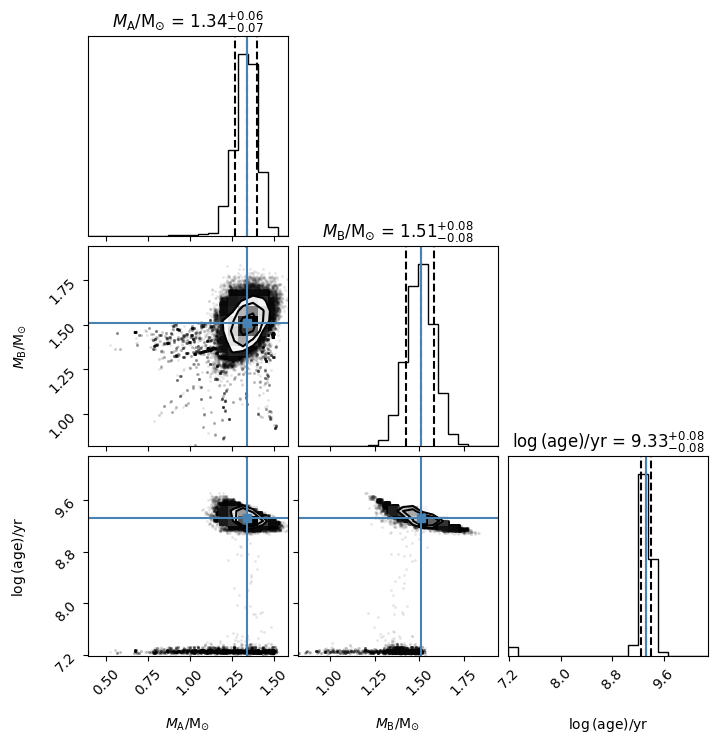

In [46]:
mass_plot_labels = np.array([f"$M_{{\\rm {subs[st]}}} / {{\\rm M_{{\\odot}}}}$" for st in range(NUM_STARS)] \
                            +["$\\log{{({{\\rm age}})}} / {{\\rm yr}}$"])

mass_fit_labels = np.array([(f"M{subs[st]}", u.Msun) for st in range(NUM_STARS)] \
                        +[("log(age)", u.dex(u.yr))])

plt.show(corner.corner(data=samples_from_sampler(mass_sampler, thin_by=thin_by, flat=True),
                       show_titles=True, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84],
                       labels=mass_plot_labels, truths=nominal_values(mass_mcmc_theta)))

In [47]:
print(f"\nFinal parameters for {target} with nominals & 1-sigma error bars from MCMC fit")
for (k, unit), theta_val in zip(mass_fit_labels, mass_mcmc_theta):
    known = ""
    if target_config.get("labels", {}).get(k, None) is not None:
        value = ufloat(target_config.labels.get(k, np.NaN), target_config.labels.get(k + "_err", 0))
        known = f"({value:.3f} {unit:unicode})"
    print(f"{k:>12s} = {theta_val:.3f} {unit:unicode} \t", known)
    target_data[k] = theta_val


Final parameters for TIC 140209204 with nominals & 1-sigma error bars from MCMC fit
          MA = 1.339+/-0.066 M☉ 	 
          MB = 1.507+/-0.078 M☉ 	 
    log(age) = 9.327+/-0.077 dex(yr) 	 
